# ESP Start-up Transient Analysis: Clustering Hard Starts
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Anomaly Detection and Reliability

## Objective
The goal of this notebook is to identify "Hard Starts" in Electrical Submersible Pumps (ESPs) using unsupervised learning. Hard starts are characterized by abnormal current spikes, prolonged ramp-up times, or high vibrations during the initial startup phase.

We will use **K-Means Clustering** to group startup signatures into distinct categories without requiring labeled historical data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plot styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Data Loading
We will load a dataset containing summarized features extracted from high-frequency sensor data during the first 60 seconds of ESP operation.

**Features:**
* `peak_amps`: The maximum current recorded during startup.
* `steady_amps`: The average current after the motor stabilizes.
* `ramp_up_time_sec`: Time taken to reach operating frequency.
* `max_vibration_g`: Maximum vibration recorded during startup.

In [2]:
# Load the dataset
# Ensure the csv is in the 'data' folder relative to this notebook
df = pd.read_csv('esp_startup_data.csv')

# Display first 5 rows
df.head()

,start_id,peak_amps,steady_amps,ramp_up_time_sec,max_vibration_g
0,START_000,57.776240,50.318902,5.279041,0.250526
1,START_001,59.061051,50.542560,4.536582,0.176714
2,START_002,54.774902,50.950370,5.816445,0.123806
3,START_003,58.183952,48.587696,6.465649,0.188711
4,START_004,65.118976,50.394233,5.122219,0.174228


## 2. Exploratory Data Analysis (EDA)
Before clustering, let's visualize the relationship between **Peak Amps** and **Ramp-up Time**. We expect "Hard Starts" to have higher values in both categories.

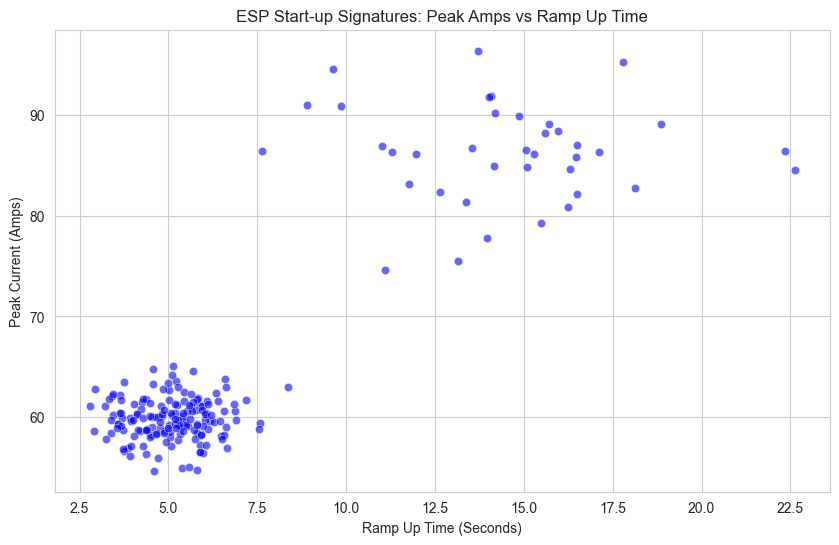

In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ramp_up_time_sec', y='peak_amps', color='blue', alpha=0.6)
plt.title('ESP Start-up Signatures: Peak Amps vs Ramp Up Time')
plt.xlabel('Ramp Up Time (Seconds)')
plt.ylabel('Peak Current (Amps)')
plt.show()

## 3. Feature Engineering
We will create a new feature called `overshoot_ratio`. This quantifies how much the current spikes relative to the steady-state operation.

$$Overshoot = \frac{Peak Amps}{Steady Amps}$$

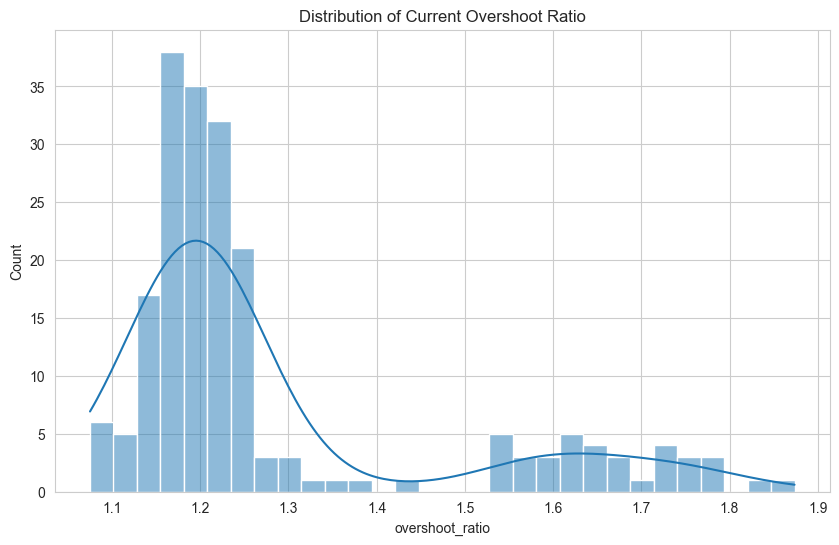

In [4]:
df['overshoot_ratio'] = df['peak_amps'] / df['steady_amps']

# Visualize the distribution of the new feature
sns.histplot(df['overshoot_ratio'], bins=30, kde=True)
plt.title('Distribution of Current Overshoot Ratio')
plt.show()

## 4. Data Preprocessing
K-Means is distance-based, so it is highly sensitive to the scale of the data. We must normalize our features using `StandardScaler` to ensure that features like Current (Amps) and Vibration (G-force) contribute equally to the distance calculation.

In [6]:
# Select features for clustering
features = ['peak_amps', 'ramp_up_time_sec', 'max_vibration_g', 'overshoot_ratio']
X = df[features]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the scaled values (mean ~ 0, std ~ 1)
print(f"Mean: {np.mean(X_scaled):.2f}, Std: {np.std(X_scaled):.2f}")

Mean: 0.00, Std: 1.00


## 5. Model Training: K-Means Clustering
We will use the **Elbow Method** to determine the optimal number of clusters. We are looking for the "elbow" point where adding more clusters yields diminishing returns in reducing inertia (sum of squared distances).

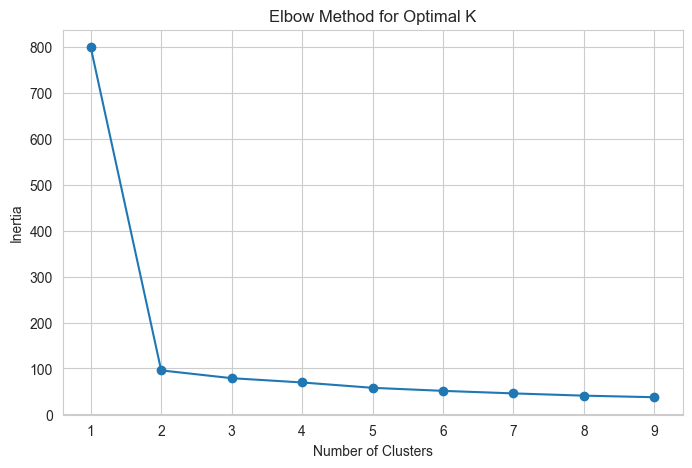

In [7]:
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

**Observation:** The elbow appears clearly at **K=2** or **K=3**. Given the physical context (Normal vs. Hard Starts), we will proceed with **K=2** to create a binary classification.

In [8]:
# Fit K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to the dataframe
df['cluster'] = clusters

# Analyze the centroids (mean values of each cluster)
cluster_summary = df.groupby('cluster')[features].mean()
print(cluster_summary)

         peak_amps  ramp_up_time_sec  max_vibration_g  overshoot_ratio
cluster                                                               
0        59.830785          5.070793         0.197757         1.195043
1        86.210374         14.523102         0.822602         1.647262


## 6. Interpreting the Results
Let's visualize the clusters to label them correctly.
* **Cluster 0:** Likely "Normal Starts" (Lower Peak Amps, Faster Ramp up).
* **Cluster 1:** Likely "Hard Starts" (Higher Peak Amps, Slower Ramp up).

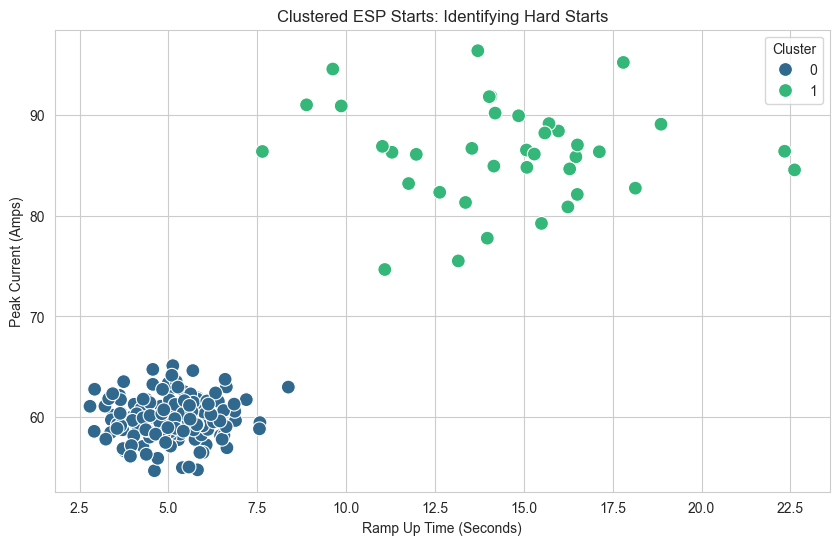

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ramp_up_time_sec', y='peak_amps', hue='cluster', palette='viridis', s=100)
plt.title('Clustered ESP Starts: Identifying Hard Starts')
plt.xlabel('Ramp Up Time (Seconds)')
plt.ylabel('Peak Current (Amps)')
plt.legend(title='Cluster')
plt.show()

## 7. Conclusion & Next Steps
We successfully separated the start-up events into two distinct behaviors.

**Insights:**
* Wells in the "Hard Start" cluster show significantly higher vibration and current overshoot.
* These wells should be flagged for **Soft Start tuning** (adjusting VSD ramp rates) or checked for mechanical sticking (scale/debris).

**Next Steps:**
1.  Integrate this model into the real-time VSD data stream.
2.  Set up automated email alerts when a start falls into the "Hard Start" cluster.